In [41]:
import time
import numpy as np
from matplotlib import pyplot as plt
from utils import *
from scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_t as mvt 
from tqdm import tqdm

In [43]:
np.random.seed(131)
x_points, y_points, line_segments = track_example1()
trajectory = MPCTrajectory(x_points, y_points, line_segments, savepath='output/track_1.pkl')
states, measurements = trajectory.get_data()
states = states[::2]
measurements = measurements[::2]
n = len(states)

model = StateSpaceModel()
Q, R, f, h = model.get_linear_model_function()

In [44]:
measurements2 = measurements.copy()
measurements2[50, 1] = 20

In [47]:
particle_filter_5 = PFC(f, h, Q, R, c, dim_m = 4, dim_y = 2, constrained_method='line2', distribution='normal')
state_estimates_con_5, cov_estimates_con_5, particle_history_con_5, weights_history_con_5, resampled_history_con_5 = particle_filter_5.filter(measurements2, verbose=True)
state_estimates_smoothed_con_5, cov_estimates_smoothed_con_5 = particle_filter.smoother(state_estimates_con_5, cov_estimates_con_5, particle_history_con_5, weights_history_con_5, verbose=True)

  0%|          | 0/171 [00:00<?, ?it/s]

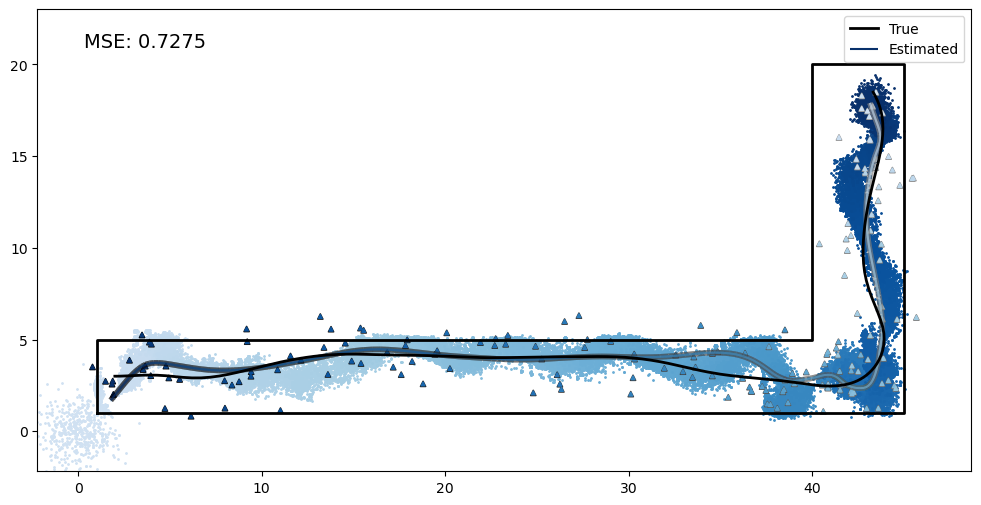

In [ ]:
plot_particle_solution(states, state_estimates_smoothed_con_3, measurements, particle_history_con_5, line_segments)

### Impossible Examples

In [29]:
c = make_constraint(line_segments[0])
particle_filter = PFC(f, h, Q, R, c, dim_m = 4, dim_y = 2, constrained_method='none', distribution='normal', N = 500)
#particle_filter = PF(f, h, Q, R, dim_m = 4, dim_y = 2)
state_estimates_con, cov_estimates_con, particle_history_con, weights_history_con, resampled_history_con = particle_filter.filter(measurements, verbose=True)
state_estimates_smoothed_con, cov_estimates_smoothed_con = particle_filter.smoother(state_estimates_con, cov_estimates_con, particle_history_con, weights_history_con, verbose=True)

  0%|          | 0/432 [00:00<?, ?it/s]

  0%|          | 1/432 [00:00<?, ?it/s]

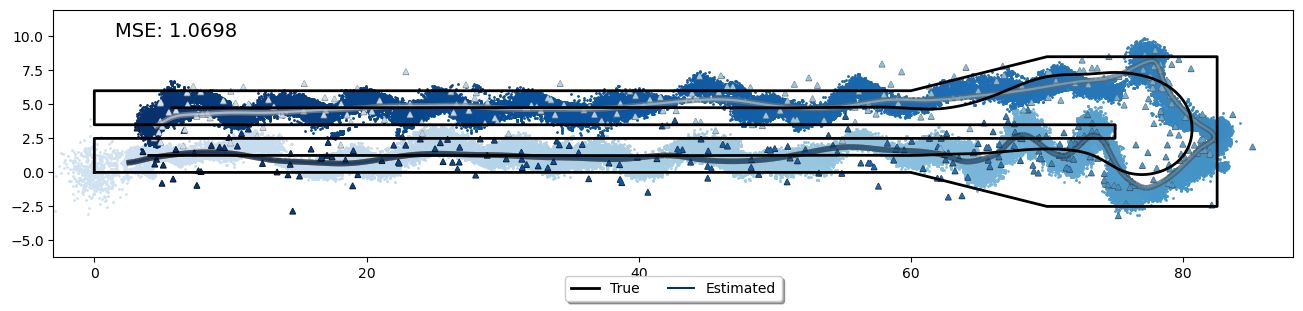

In [30]:
plot_particle_solution(states, state_estimates_smoothed_con, measurements, particle_history_con, line_segments)

In [36]:
c = make_constraint(line_segments[0])
particle_filter = PFC(f, h, Q, R, c, dim_m = 4, dim_y = 2, constrained_method='accept_reject', distribution='normal', N = 500)
#particle_filter = PF(f, h, Q, R, dim_m = 4, dim_y = 2)
state_estimates_con, cov_estimates_con, particle_history_con, weights_history_con, resampled_history_con = particle_filter.filter(measurements, verbose=True)
state_estimates_smoothed_con, cov_estimates_smoothed_con = particle_filter.smoother(state_estimates_con, cov_estimates_con, particle_history_con, weights_history_con, verbose=True)

  0%|          | 0/432 [00:00<?, ?it/s]

  0%|          | 1/432 [00:00<?, ?it/s]

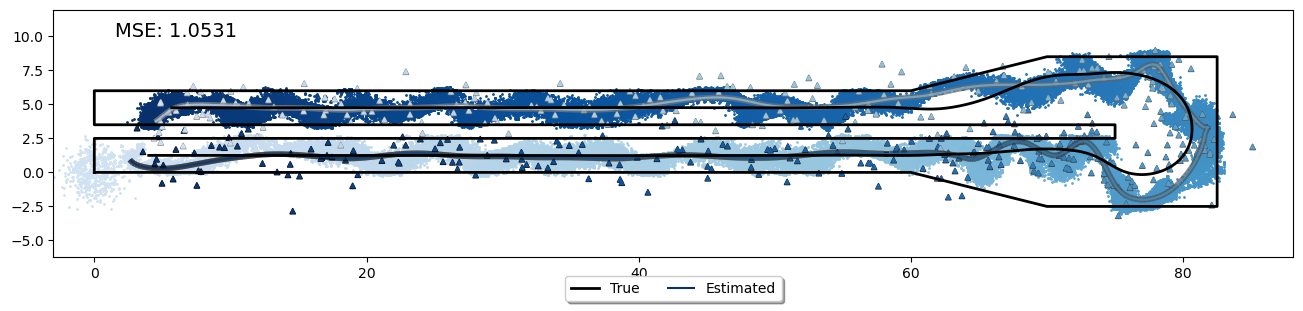

In [37]:
plot_particle_solution(states, state_estimates_smoothed_con, measurements, particle_history_con, line_segments)